### Generative Adversarial Network
 [MNIST](https://yann.lecun.com/exdb/mnist/)

In [134]:
skip_training = False   

max_epochs = 20
noise_size = 100
batch_size = 32
feedback_txt =  []

<h3>Import all the necessary libraries </h3>

In [136]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from unittest.mock import patch, MagicMock

<h3> Select the device to run the model.</h3>


In [137]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h3> Download the dataset and create a dataloader to loop through mini batches of data. </h3>

In [138]:
dataset_path = './dataset_gan' 

#### Dataset

##### Creating Pytorch Dataset and Dataloader

In [140]:
#MNIST dataset
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
dataset = MNIST(root=dataset_path,
                train=True,
                transform=transform,
                download=True,)

train_size = 0.8
test_size = 0.2
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h3>Visualizing data</h3>


Batch shape: torch.Size([32, 1, 32, 32])


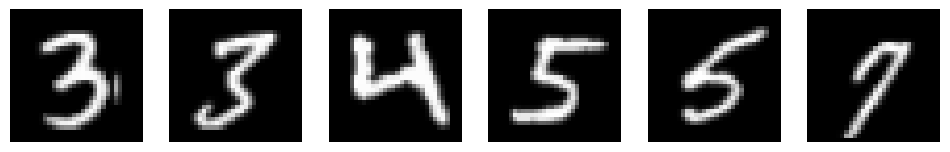

In [141]:
batch, _ = next(iter(train_loader))
displayed_images = batch[:6].squeeze(1)
fig, ax = plt.subplots(1, 6, figsize=(12, 4))

for i in range(6):
    ax[i].imshow(displayed_images[i], cmap='gray')
    ax[i].axis('off')

print(f"Batch shape: {batch.shape}")

<h3>Define the Model classes.</h3>

<h4>Define the Discriminator class</h4>

In [142]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1=nn.Conv2d(1,64,4,2,1)
        self.conv2=nn.Conv2d(64,128,4,2,1)
        self.conv3=nn.Conv2d(128,256,4,2,1)
        self.conv4=nn.Conv2d(256,1,4,1,0)

        self.batchnorm1=nn.BatchNorm2d(64)
        self.batchnorm2=nn.BatchNorm2d(128)
        self.batchnorm3=nn.BatchNorm2d(256)

        self.relu=nn.ReLU()
        self.sig=nn.Sigmoid()



    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.relu(x)

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.relu(x)

        x=self.conv4(x).squeeze(2,3)
        x=self.sig(x)

        return x










<h4>Define the Generator class</h4>

In [145]:
class Generator(nn.Module):
    def __init__(self,
                 noise_size:int,
                 ) -> None:
        super().__init__()

        self.conv1=nn.ConvTranspose2d(noise_size,256,4,1,0)
        self.conv2=nn.ConvTranspose2d(256,128,4,2,1)
        self.conv3=nn.ConvTranspose2d(128,64,4,2,1)
        self.conv4=nn.ConvTranspose2d(64,1,4,2,1)

        self.batchnorm1=nn.BatchNorm2d(256)
        self.batchnorm2=nn.BatchNorm2d(128)
        self.batchnorm3=nn.BatchNorm2d(64)

        self.relu=nn.ReLU()
        self.tan=nn.Tanh()

    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.relu(x)

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.relu(x)

        x=self.conv4(x)
        x=self.tan(x)

        return x

<h3> Define the loss function and optimizer.</h3>

In [148]:
def loss_and_optimizer(generator:Generator,
                       discriminator:Discriminator) -> tuple:
    
    lr_gen=0.001
    lr_dis=0.0001
    b1=0.5
    b2=0.999
    betas=(b1,b2)
    criterion=nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen,betas=betas)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_dis,betas=betas)

    return criterion, g_optimizer, d_optimizer

In [149]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)

<h3> Training loop.</h3>

<h4>Define discriminator loss </h4>

In [152]:
def forward_discriminator(generator: Generator,
                           discriminator: Discriminator,
                           criterion: nn.Module,
                           real_images: torch.Tensor,
                           noise: torch.Tensor,
                           device: torch.device) -> tuple:
    

    batch_size = real_images.size(0)
    real_labels=torch.ones(batch_size, 1, device=device)
    fake_images=generator(noise).detach()
    fake_labels=torch.zeros(batch_size, 1, device=device)
    discriminator_output_fake=discriminator(fake_images)
    discriminator_output_real=discriminator(real_images)

    loss_fake=criterion(discriminator_output_fake,fake_labels)
    loss_real=criterion(discriminator_output_real,real_labels)
    loss=loss_fake+loss_real


    return loss, real_labels, fake_labels


<h4>Define generator loss </h4>

In [155]:
def forward_generator(generator: Generator,
                        discriminator: Discriminator,
                        criterion: nn.Module,
                        noise: torch.Tensor,
                        device: torch.device) -> tuple:
    
    fake_images=generator(noise)
    batch_size = fake_images.size(0)
    fake_labels=torch.ones(batch_size, 1, device=device)
    discriminator_output_fake=discriminator(fake_images)
    loss=criterion(discriminator_output_fake,fake_labels)
    return loss,discriminator_output_fake

<h4>Define training loop.</h4>

In [158]:
test_img = torch.randn(64, 100, 1, 1).to(device) # fixed noise for visualization during training

def train_gan(generator: Generator,
              discriminator: Discriminator,
              g_optimizer: torch.optim.Optimizer,
              d_optimizer: torch.optim.Optimizer,
              train_dataloader: DataLoader,
              noise_size: torch.Tensor,
              loss: nn.Module,
              device: torch.device,
              max_epochs: int = 20,
              verbose: bool = True) -> tuple:
    
    generator_losses = []
    discriminator_losses = []

    generator.train()
    discriminator.train()

    for epoch in range(max_epochs):
        generator_batch_losses = []
        discriminator_batch_losses = []
        for i, (real_images, _) in enumerate(train_dataloader):

            
            real_images=real_images.to(device)
            noise=torch.randn((real_images.size(0)), noise_size, 1, 1,device=device)

            
            d_optimizer.zero_grad()
            d_loss, _, _ = forward_discriminator(generator, discriminator,criterion, real_images, noise, device)
            d_loss.backward()
            d_optimizer.step()


            
            g_optimizer.zero_grad()
            g_loss, _, = forward_generator(generator, discriminator,criterion, noise, device)
            g_loss.backward()
            g_optimizer.step()

            generator_batch_losses.append(g_loss.item())
            discriminator_batch_losses.append(d_loss.item())

        # Visualize the generated images during training on fixed noise
        if verbose:
            print(f"Epoch {epoch}: Generator loss: {np.mean(generator_batch_losses):.2f}. Discriminator loss: {np.mean(discriminator_batch_losses):2f}")
            if epoch % 5 == 0:
                sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
                nrow, ncols = 1, 5
                fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(6,1.5))
                plt.suptitle(f'Epoch : {epoch}')
                for ncol in range(ncols):
                    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
                    axes[ncol].axis('off')
                plt.show()

        generator_losses.append(np.mean(generator_batch_losses))
        discriminator_losses.append(np.mean(discriminator_batch_losses))

    return generator_losses, discriminator_losses

Epoch 0: Generator loss: 1.98. Discriminator loss: 0.695364


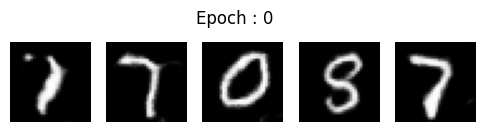

Epoch 1: Generator loss: 2.53. Discriminator loss: 0.504376
Epoch 2: Generator loss: 3.39. Discriminator loss: 0.305616
Epoch 3: Generator loss: 4.17. Discriminator loss: 0.196487
Epoch 4: Generator loss: 4.71. Discriminator loss: 0.175031
Epoch 5: Generator loss: 4.96. Discriminator loss: 0.131132


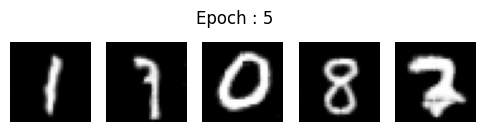

Epoch 6: Generator loss: 5.30. Discriminator loss: 0.131518
Epoch 7: Generator loss: 5.39. Discriminator loss: 0.135977
Epoch 8: Generator loss: 5.70. Discriminator loss: 0.084797
Epoch 9: Generator loss: 5.44. Discriminator loss: 0.151317
Epoch 10: Generator loss: 5.88. Discriminator loss: 0.156666


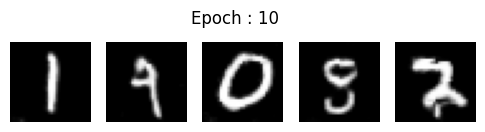

Epoch 11: Generator loss: 6.15. Discriminator loss: 0.085109
Epoch 12: Generator loss: 5.74. Discriminator loss: 0.137118
Epoch 13: Generator loss: 7.18. Discriminator loss: 0.024048
Epoch 14: Generator loss: 5.71. Discriminator loss: 0.225647
Epoch 15: Generator loss: 6.65. Discriminator loss: 0.063837


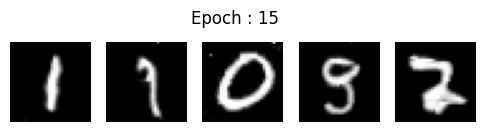

Epoch 16: Generator loss: 6.84. Discriminator loss: 0.109938
Epoch 17: Generator loss: 6.02. Discriminator loss: 0.096456
Epoch 18: Generator loss: 6.54. Discriminator loss: 0.055715
Epoch 19: Generator loss: 6.47. Discriminator loss: 0.078963
Your trained model is saved successfully!


In [161]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

if not skip_training:
    criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)
    gen_losses, disc_losses = train_gan(generator, discriminator, g_optimizer, d_optimizer, train_loader, noise_size, criterion, device, max_epochs=max_epochs, verbose=True)
    torch.save(generator.state_dict(), 'best_generator.pth')
    torch.save(discriminator.state_dict(), 'best_discriminator.pth')
    print("Your trained model is saved successfully!")
else:
    generator.load_state_dict(torch.load('best_generator.pth', map_location=device))
    discriminator.load_state_dict(torch.load('best_discriminator.pth', map_location=device))

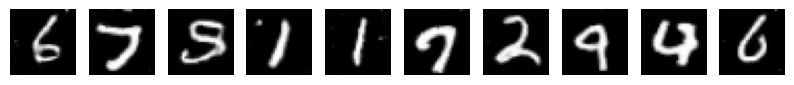

In [162]:
test_img = torch.randn(64, 100, 1, 1).to(device)
sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
nrow, ncols = 1, 10
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(10,1.5))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()

<h4>Visualizing Generated Images & Computing FID Score</h4>

In [164]:
!pip install torchmetrics[image]

In [165]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=64).to(device)

# sample_gen_imgs_in_train shape: [64, 28, 28]
gen_imgs = sample_gen_imgs_in_train.unsqueeze(1).to(device)  # [64,1,28,28]

real_batch, _ = next(iter(train_loader))
real_imgs = real_batch[:gen_imgs.size(0)].to(device)

def preprocess_for_fid(x):
    x = (x + 1) / 2 if x.min() < 0 else x
    # grayscale → RGB (Inception expects 3 channels)
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    # scale to [0,255] and convert to uint8
    x = (x * 255).clamp(0, 255).to(torch.uint8)
    return x

real_imgs = preprocess_for_fid(real_imgs)
gen_imgs = preprocess_for_fid(gen_imgs)

# --------- Updating FID metric ------------
fid.update(real_imgs, real=True)
fid.update(gen_imgs, real=False)

# ---------- Computing and print ----------
fid_score = fid.compute().item()
print(f"\nFID between displayed generated images & real samples: {fid_score:.2f}")

if fid_score < 0.05:
    print(" Excellent — generated digits are very close to real MNIST distribution.")
elif fid_score < 0.1:
    print(" Decent — generator is learning structure but can improve.")
else:
    print(" High FID — generated samples differ noticeably from real digits.")



🧮 FID between displayed generated images & real samples: 0.02
 Excellent — generated digits are very close to real MNIST distribution.


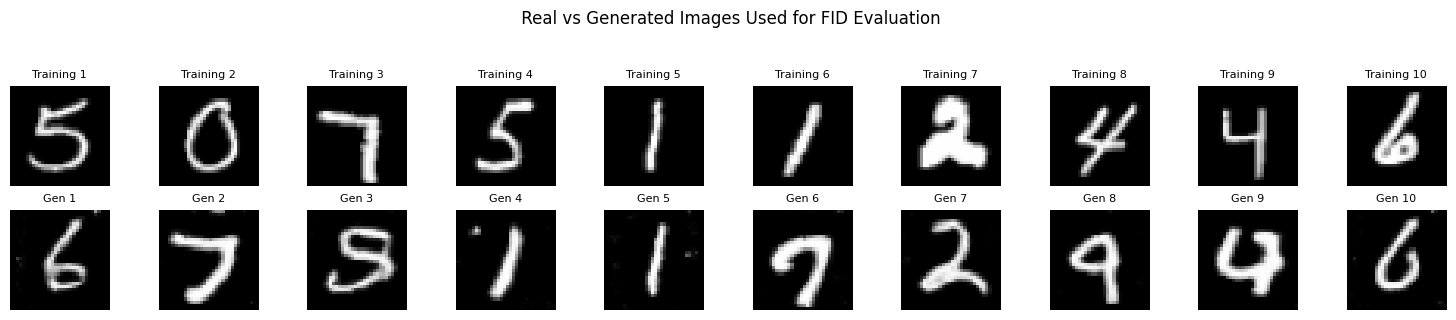

In [166]:
import matplotlib.pyplot as plt
import torch

def to_display(x):
    #Normalizing to [0,1] if input is [-1,1]
    x = (x + 1) / 2 if x.min() < 0 else x
    x = x.clamp(0, 1)
    if x.shape[1] == 1:  #expanding grayscale to 3 channels for consistent display
        x = x.repeat(1, 3, 1, 1)
    return x

#Ensuring both tensors are compatible
n = min(len(real_imgs), len(gen_imgs))
real_disp = to_display(real_imgs[:n].float() / 255.0)
gen_disp = to_display(gen_imgs[:n].float() / 255.0)

#Visualization settings
n_show = min(10, n)  #number of pairs to show
fig, axes = plt.subplots(2, n_show, figsize=(n_show * 1.5, 3))

for i in range(n_show):
    #Real image
    axes[0, i].imshow(real_disp[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    axes[0, i].set_title(f"Training {i+1}", fontsize=8)
    axes[0, i].axis('off')

    #Generated image
    axes[1, i].imshow(gen_disp[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    axes[1, i].set_title(f"Gen {i+1}", fontsize=8)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Training Images", fontsize=10)
axes[1, 0].set_ylabel("Generated Images", fontsize=10)
plt.suptitle(" Real vs Generated Images Used for FID Evaluation", fontsize=12, y=1.05)
plt.tight_layout()
plt.show()
